In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn. linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
data_path = '../../data/box_builder_dataset/feature_frame.parquet'
df = pd.read_parquet(data_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


First of all, let's divide our columns into informative and features and definde de target variable.

After that, we are clasifying the columns into numerical, categorical and binary columns.

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

We need only the orders with at least 5 items on them

In [6]:
def get_relevant_dataframe(df: pd.DataFrame, min_products: int=5) -> pd.DataFrame:
    """We are only interested in big enough orders that are profitable"""
    order_sizes = df.groupby('order_id').outcome.sum()
    big_enough_orders = order_sizes[order_sizes >= min_products].index
    return df[df.order_id.isin(big_enough_orders)].copy()

In [7]:
df_relevant = (
    df
    .pipe(get_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

Let's check that we have a larger amount of data before filtering:

In [8]:
df['order_id'].nunique() > df_relevant['order_id'].nunique()

True

As there is a date variable, let's see if the data behaves differently in different periods of time.

In [9]:
daily_orders = df_relevant.groupby('order_date').order_id.nunique()

In [10]:
daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     6
2020-10-08    12
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

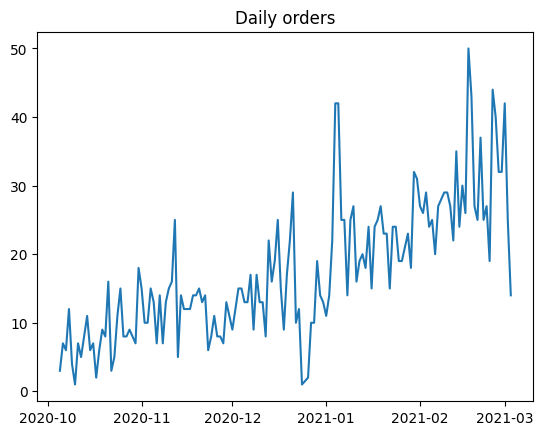

In [11]:
plt.plot(daily_orders, label='Daily orders')
plt.title('Daily orders')

As the number of orders is increasing over time, we will split the data into training and testing sets using a time-based split.

By doing this, we will be able to evaluate the model's performance on the most recent data and avoid data leakage.

In [12]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())


Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


In [13]:
train_df = df_relevant[df_relevant.order_date <= train_val_cutoff]
val_df = df_relevant[(df_relevant.order_date > train_val_cutoff) & (df_relevant.order_date <= val_test_cutoff)]
test_df = df_relevant[df_relevant.order_date > val_test_cutoff]

## Baseline

To test the model, we will use the ROC curve and the precision-recall curve.

In [14]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array]=None
        ) -> None:
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, ax = figure
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    ax[0].plot(recall, precision, label=f'{model_name} PR curve (auc = {average_precision:0.2f})')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision-Recall curve')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(fpr, tpr, label=f'{model_name} ROC curve (auc = {roc_auc:0.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random')
    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title('ROC curve')
    ax[1].legend()
    ax[1].grid()
    plt.show()

In [15]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(label_col, axis=1)
    y = df[label_col]
    return X, y

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In order to be able to understand if our model is performing well, we need to establish a baseline.

We are using the model created in the previous module as a baseline and we will compare the results with the new model. 

The previous model is a simple logistic regression model with the following features: 

In [16]:
baseline_features = [
    'ordered_before',
    'abandoned_before',
    'global_popularity',
]

baseline_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', C=1.0)
)

baseline_model.fit(X_train[baseline_features], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

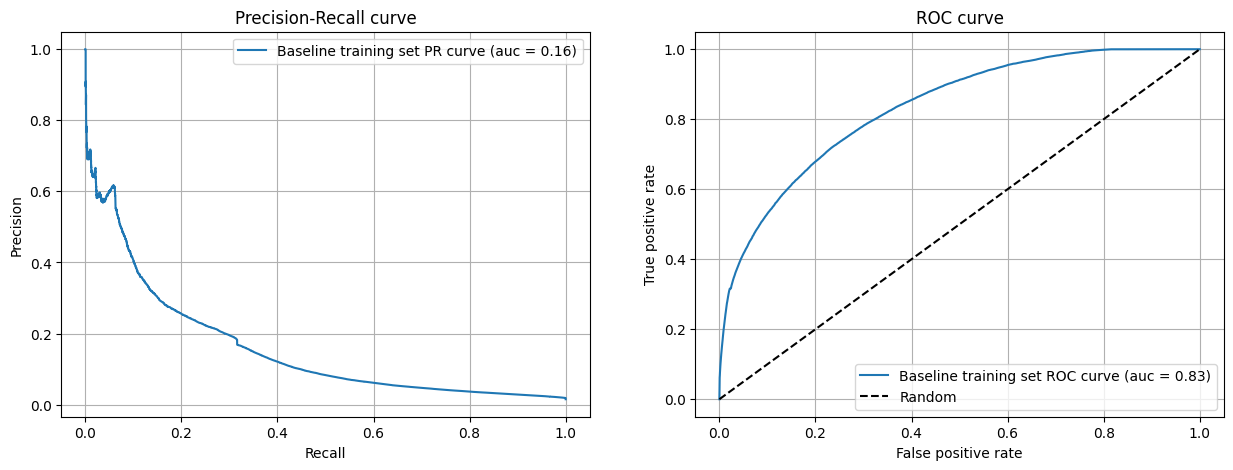

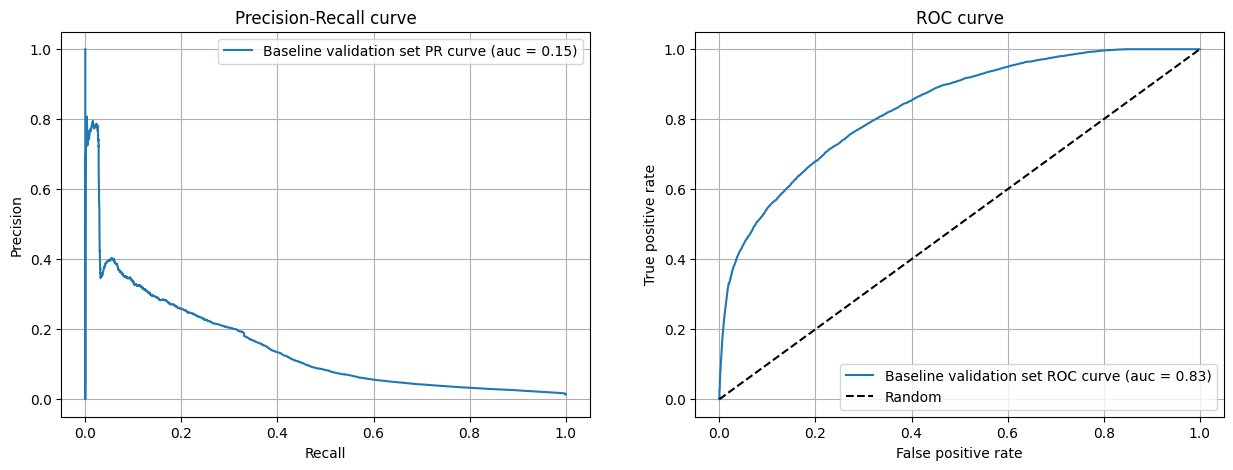

In [17]:
train_prob = baseline_model.predict_proba(X_train[baseline_features])[:, 1]
plot_metrics('Baseline training set', train_prob, y_train)

val_prob = baseline_model.predict_proba(X_val[baseline_features])[:, 1]
plot_metrics('Baseline validation set', val_prob, y_val)

We can also use a simplier baseline by using the `global_popularity` variable as a predictor.

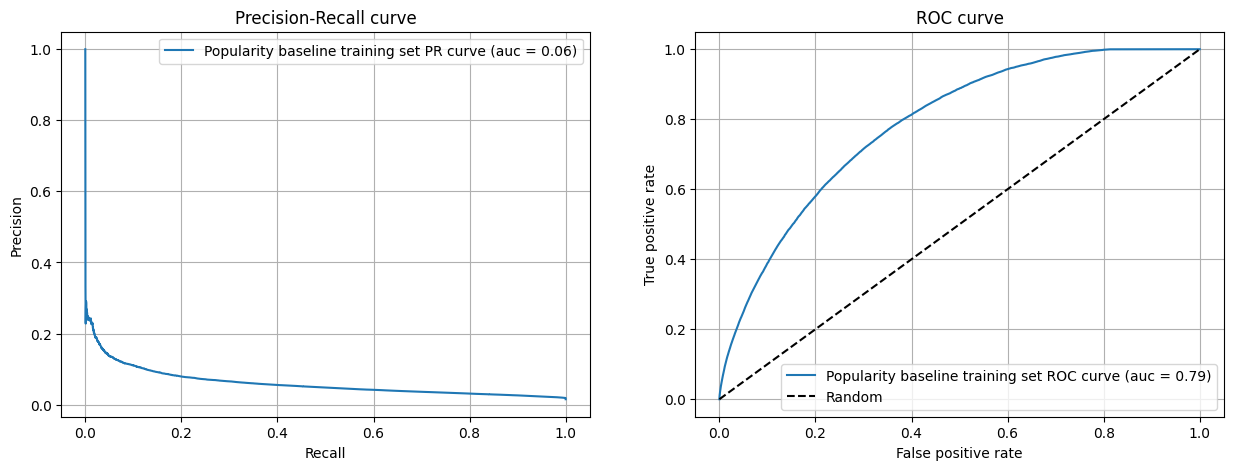

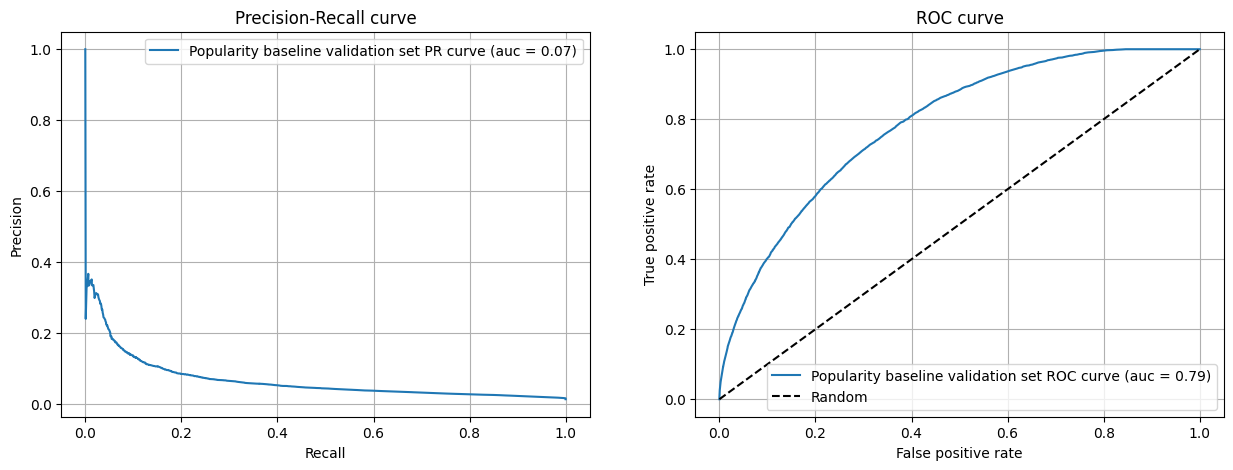

In [18]:
plot_metrics('Popularity baseline training set', train_df['global_popularity'], y_train)
plot_metrics('Popularity baseline validation set', val_df['global_popularity'], y_val)

Let's see if we can improve the baseline model by using a non linear model. Let's try a Random Forest model.

In [19]:
def print_model_metrics(model_name: str, y_true: pd.Series, y_pred: pd.Series) -> None:
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    max_f1 = np.max(2 * precision * recall / (precision + recall))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f'{model_name}:\t PR curve auc = {average_precision:0.5f}.\t Best F1 score: {max_f1:0.5f}.\t ROC curve auc = {roc_auc:0.5f}.')

Now we're defining the features that will help us to predict the target variable.

In [20]:
train_cols = numerical_cols + binary_cols

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
n_estimators = [5, 10, 20, 50, 100]
for n in n_estimators:
    for max_depth in [None, 5, 10, 20]:
        random_forest_model = RandomForestClassifier(n_estimators=n, max_depth=max_depth, n_jobs=2)

        random_forest_model.fit(X_train[train_cols], y_train)
        val_prob = random_forest_model.predict_proba(X_val[train_cols])[:, 1]

        print_model_metrics(f'Random Forest n={n} max_depth={max_depth} validation set', y_val, val_prob)

Random Forest n=5 max_depth=None validation set:	 PR curve auc = 0.07622.	 Best F1 score: 0.17141.	 ROC curve auc = 0.64707.
Random Forest n=5 max_depth=5 validation set:	 PR curve auc = 0.17462.	 Best F1 score: 0.26472.	 ROC curve auc = 0.80576.
Random Forest n=5 max_depth=10 validation set:	 PR curve auc = 0.18068.	 Best F1 score: 0.26323.	 ROC curve auc = 0.83089.
Random Forest n=5 max_depth=20 validation set:	 PR curve auc = 0.13667.	 Best F1 score: 0.21533.	 ROC curve auc = 0.80146.
Random Forest n=10 max_depth=None validation set:	 PR curve auc = 0.09114.	 Best F1 score: 0.17948.	 ROC curve auc = 0.67988.
Random Forest n=10 max_depth=5 validation set:	 PR curve auc = 0.18800.	 Best F1 score: 0.27624.	 ROC curve auc = 0.83004.
Random Forest n=10 max_depth=10 validation set:	 PR curve auc = 0.19407.	 Best F1 score: 0.27567.	 ROC curve auc = 0.83862.
Random Forest n=10 max_depth=20 validation set:	 PR curve auc = 0.15756.	 Best F1 score: 0.23524.	 ROC curve auc = 0.82519.
Random For

The best results come from the Random Forest model with n=100 and max_depth=10.

There is another model that performs very similar, the one with n=50 and max_depth=10.

I will choose the model with n=50 and max_depth=10 as the final model for simplicity.


Now let's try to improve the model by using a Gradient Boosting Tree model.

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
n_estimators = [20, 50, 100]
for learning_rate in [0.1, 0.05]:
    for depth in [1, 3, 5]:
        for n in n_estimators:
            gradient_boosting_model = GradientBoostingClassifier(n_estimators=n, learning_rate=learning_rate, max_depth=depth)

            gradient_boosting_model.fit(X_train[train_cols], y_train)
            val_prob = gradient_boosting_model.predict_proba(X_val[train_cols])[:, 1]

            print_model_metrics(f'Gradient Boosting n_estimators={n} learning_rate={learning_rate} depth={depth} validation set', y_val, val_prob)


Gradient Boosting n_estimators=20 learning_rate=0.1 depth=1 validation set:	 PR curve auc = 0.13958.	 Best F1 score: 0.24327.	 ROC curve auc = 0.80223.
Gradient Boosting n_estimators=50 learning_rate=0.1 depth=1 validation set:	 PR curve auc = 0.16242.	 Best F1 score: 0.25221.	 ROC curve auc = 0.83531.
Gradient Boosting n_estimators=100 learning_rate=0.1 depth=1 validation set:	 PR curve auc = 0.16960.	 Best F1 score: 0.25247.	 ROC curve auc = 0.83936.
Gradient Boosting n_estimators=20 learning_rate=0.1 depth=3 validation set:	 PR curve auc = 0.18212.	 Best F1 score: 0.26614.	 ROC curve auc = 0.84133.
Gradient Boosting n_estimators=50 learning_rate=0.1 depth=3 validation set:	 PR curve auc = 0.18742.	 Best F1 score: 0.27205.	 ROC curve auc = 0.84389.
Gradient Boosting n_estimators=100 learning_rate=0.1 depth=3 validation set:	 PR curve auc = 0.18778.	 Best F1 score: 0.27428.	 ROC curve auc = 0.84626.
Gradient Boosting n_estimators=20 learning_rate=0.1 depth=5 validation set:	 PR curve 

/tmp/ipykernel_3340/4145920766.py:4: RuntimeWarning: invalid value encountered in divide
  max_f1 = np.max(2 * precision * recall / (precision + recall))


Gradient Boosting n_estimators=50 learning_rate=0.1 depth=5 validation set:	 PR curve auc = 0.17875.	 Best F1 score: nan.	 ROC curve auc = 0.84680.


/tmp/ipykernel_3340/4145920766.py:4: RuntimeWarning: invalid value encountered in divide
  max_f1 = np.max(2 * precision * recall / (precision + recall))


Gradient Boosting n_estimators=100 learning_rate=0.1 depth=5 validation set:	 PR curve auc = 0.17674.	 Best F1 score: nan.	 ROC curve auc = 0.84651.
Gradient Boosting n_estimators=20 learning_rate=0.05 depth=1 validation set:	 PR curve auc = 0.10922.	 Best F1 score: 0.23541.	 ROC curve auc = 0.74125.
Gradient Boosting n_estimators=50 learning_rate=0.05 depth=1 validation set:	 PR curve auc = 0.14177.	 Best F1 score: 0.24530.	 ROC curve auc = 0.81091.
Gradient Boosting n_estimators=100 learning_rate=0.05 depth=1 validation set:	 PR curve auc = 0.16282.	 Best F1 score: 0.25202.	 ROC curve auc = 0.83127.
Gradient Boosting n_estimators=20 learning_rate=0.05 depth=3 validation set:	 PR curve auc = 0.16421.	 Best F1 score: 0.25265.	 ROC curve auc = 0.82257.
Gradient Boosting n_estimators=50 learning_rate=0.05 depth=3 validation set:	 PR curve auc = 0.18644.	 Best F1 score: 0.27224.	 ROC curve auc = 0.84078.
Gradient Boosting n_estimators=100 learning_rate=0.05 depth=3 validation set:	 PR cur

/tmp/ipykernel_3340/4145920766.py:4: RuntimeWarning: invalid value encountered in divide
  max_f1 = np.max(2 * precision * recall / (precision + recall))


The best results come from the Gradient Boosting Tree model with n_estimators=50 learning_rate=0.05 depth=5,
followed by the model with n_estimators=100 learning_rate=0.05 depth=5.

I will choose the model with n_estimators=50 learning_rate=0.05 depth=5 as the representative model for the Gradient Boosting Tree model, as it gives the best results and is simpler.

Now let's get the tree models and compare them to the baseline models

In [26]:
gradient_boosting_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.05, max_depth=5)
gradient_boosting_model.fit(X_train[train_cols], y_train)

random_forest_model = RandomForestClassifier(n_estimators=50, max_depth=10)
random_forest_model.fit(X_train[train_cols], y_train)

RandomForestClassifier(max_depth=10, n_estimators=50)

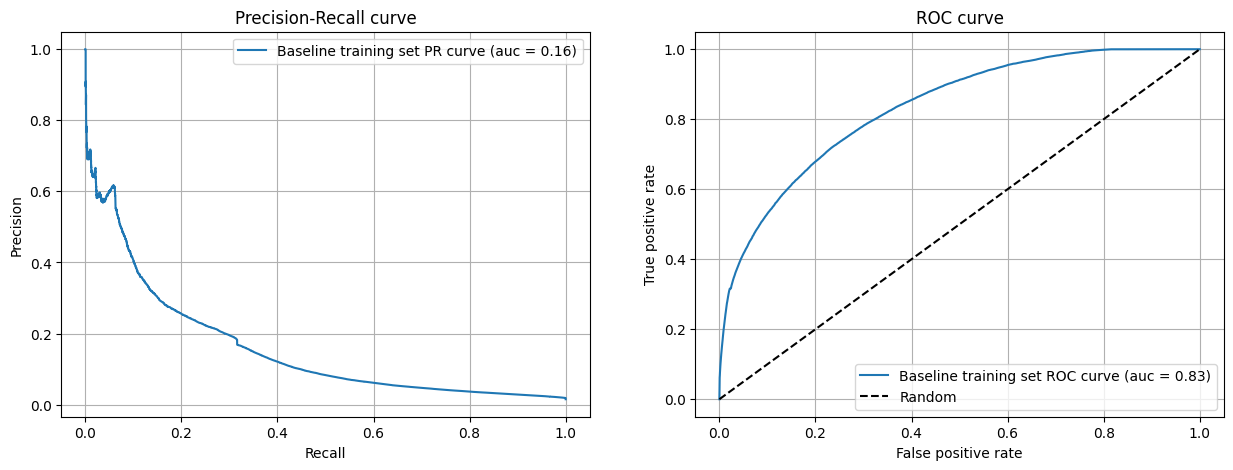

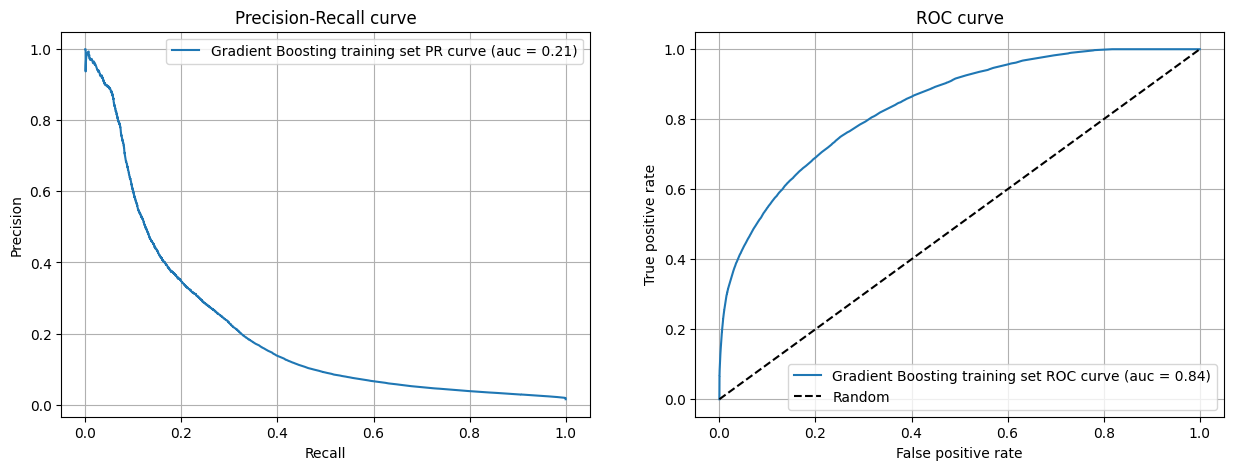

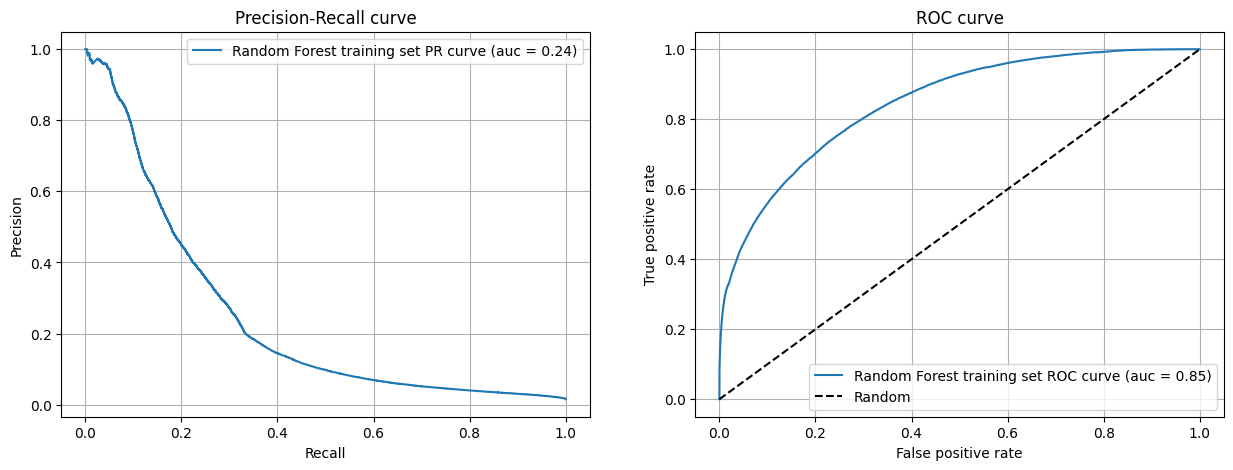

In [29]:
plot_metrics('Baseline training set', baseline_model.predict_proba(X_train[baseline_features])[:, 1], y_train)

plot_metrics('Gradient Boosting training set', gradient_boosting_model.predict_proba(X_train[train_cols])[:, 1], y_train)

plot_metrics('Random Forest training set', random_forest_model.predict_proba(X_train[train_cols])[:, 1], y_train)

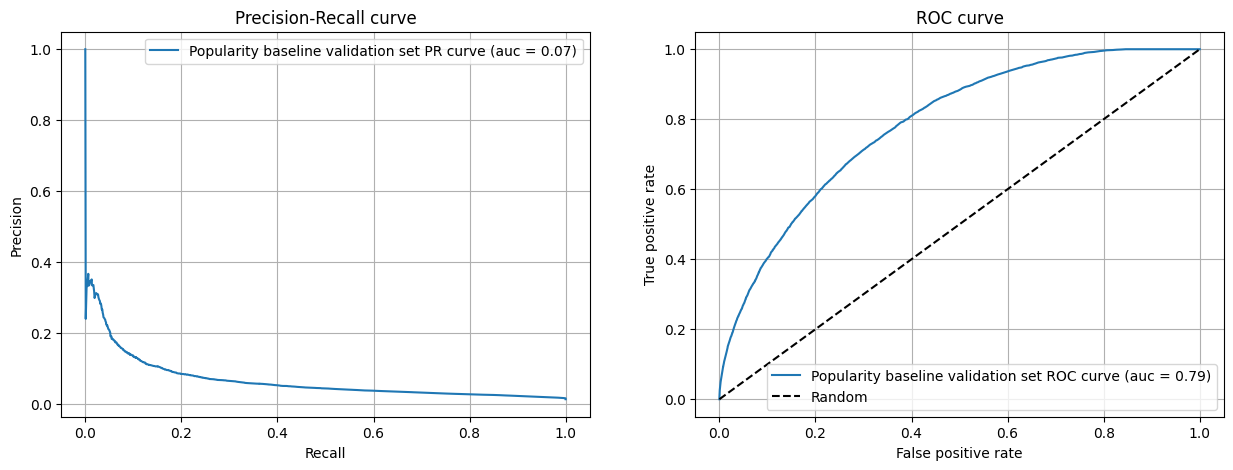

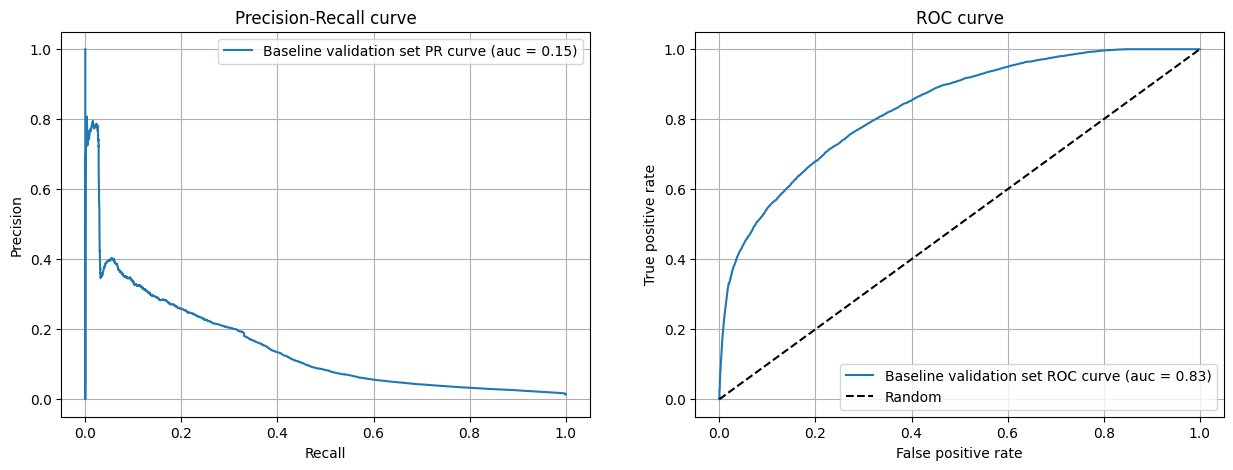

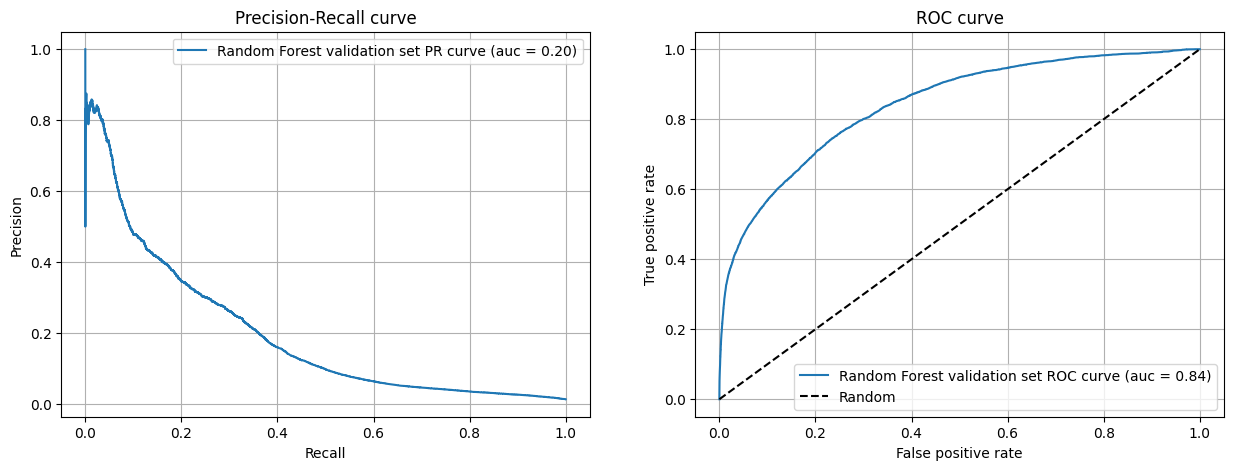

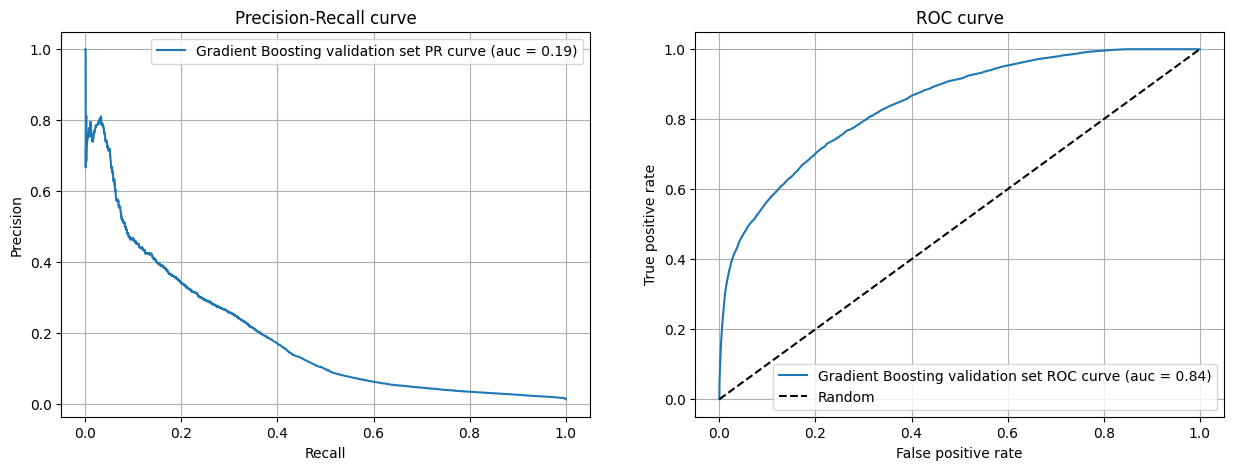

In [28]:
plot_metrics('Popularity baseline validation set', val_df['global_popularity'], y_val)

plot_metrics('Baseline validation set', baseline_model.predict_proba(X_val[baseline_features])[:, 1], y_val)

plot_metrics('Random Forest validation set', random_forest_model.predict_proba(X_val[train_cols])[:, 1], y_val)

plot_metrics('Gradient Boosting validation set', gradient_boosting_model.predict_proba(X_val[train_cols])[:, 1], y_val)

We can see that the non linear models perform better than the baseline model, which is linear.
The Random Forest Tree model is performing very similar to the Gradient Boosting Tree model, with a slightly better performance in the precision-recall curve.

There are other ways to improve the model, such as using a different feature selection method.
It is not covered in this notebook, but it is a good idea to try different feature selection methods to see if we can improve the model.

In order to get more metrics, let's use the confusion matrix.

First, let's get the predictions probabilities and find a threshold that gives us the best results. We will use the F1 score as the metric to find the best threshold.

In [39]:
def get_best_threshold(y_true: pd.Series, y_pred: pd.Series) -> float:
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f1 = 2 * precision * recall / (precision + recall)
    return thresholds[np.argmax(f1)]


In [41]:
random_forest_val_pred = random_forest_model.predict_proba(X_val[train_cols])[:, 1]
random_forest_threshold = get_best_threshold(y_val, random_forest_val_pred)

gradient_boosting_val_pred = gradient_boosting_model.predict_proba(X_val[train_cols])[:, 1]
gradient_boosting_threshold = get_best_threshold(y_val, gradient_boosting_val_pred)

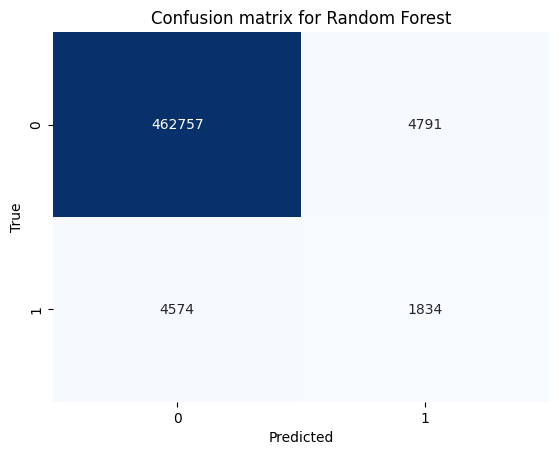

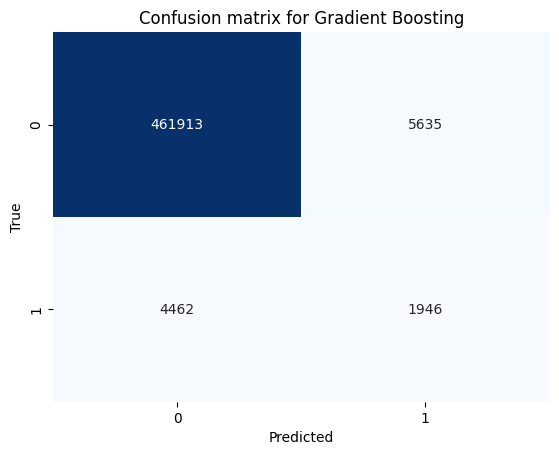

In [47]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, threshold: float, model_name: str) -> None:
    y_pred_binary = y_pred > threshold
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()

plot_confusion_matrix(y_val, random_forest_val_pred, random_forest_threshold, 'Random Forest')

plot_confusion_matrix(y_val, gradient_boosting_val_pred, gradient_boosting_threshold, 'Gradient Boosting')

Now we can use the best threshold to get the confusion matrix and the accuracy for that threshold.

In [46]:
accuracy_random_forest = (random_forest_model.predict_proba(X_val[train_cols])[:, 1] > random_forest_threshold).mean()
accuracy_gradient_boosting = (gradient_boosting_model.predict_proba(X_val[train_cols])[:, 1] > gradient_boosting_threshold).mean()

print(f'Random Forest accuracy: {accuracy_random_forest:0.5f}')
print(f'Gradient Boosting accuracy: {accuracy_gradient_boosting:0.5f}')

Random Forest accuracy: 0.01398
Gradient Boosting accuracy: 0.01600


The gradient boosting tree model is slightly better than the random forest tree model, with a better accuracy and F1 score. Let's use this model as the final model.

## Test the model

To test the model, we will use the testing set that we created before. We will use the same metrics as before to evaluate the model's performance and see if it is consistent with the training set.

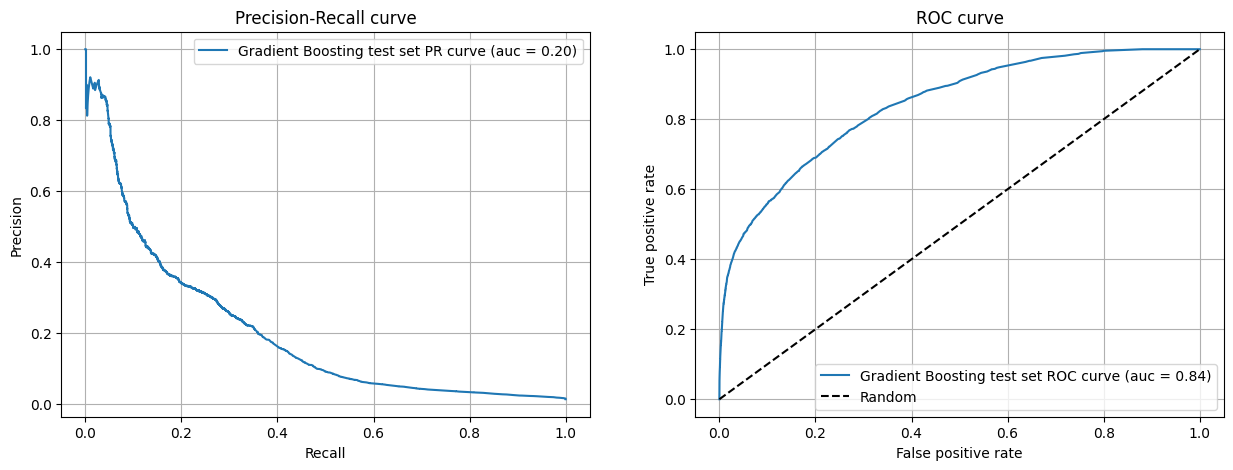

In [48]:
gradient_boosting_test_pred = gradient_boosting_model.predict_proba(X_test[train_cols])[:, 1]

plot_metrics('Gradient Boosting test set', gradient_boosting_test_pred, y_test)

The precision-recall curve is consistent with the results before. this means that the model is performing well on the most recent data. Same for the ROC curve.

0.1539743097648426


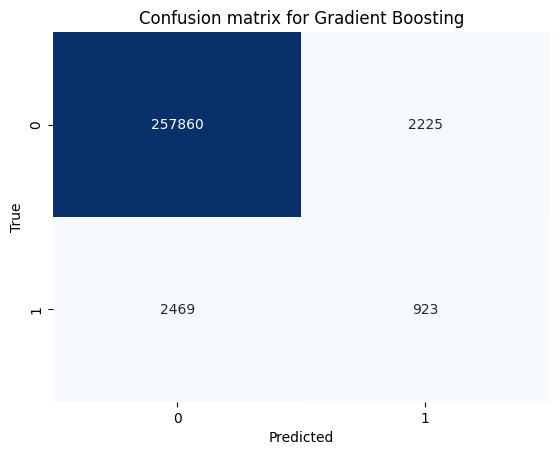

In [52]:
best_test_threshold = get_best_threshold(y_test, gradient_boosting_test_pred)
print(best_test_threshold)
plot_confusion_matrix(y_test, gradient_boosting_test_pred, best_test_threshold, 'Gradient Boosting')

The confusion matrix shows that the model is predicting a very low true positive rate compared to the true negative rate. This also happened in the validation set.

It may be due to the fact that the data is imbalanced, with a lot of negative cases and few positive cases.

In [51]:
accuracy_gradient_boosting_test = (gradient_boosting_model.predict_proba(X_test[train_cols])[:, 1] > best_test_threshold).mean()
accuracy_gradient_boosting_test

0.011947911961954933

The accuracy is also consistent with the results before.

## Conclusion

- We have improved the baseline model by using non linear models, such as the Random Forest Tree model and the Gradient Boosting Tree model.

- The Random Forest Tree model is performing very similar to the Gradient Boosting Tree model, with a slightly better performance in the precision-recall curve.

- The gradient boosting tree model is performing well on the testing set, with consistent results with the training set.

- The model is predicting a very low true positive rate compared to the true negative rate, which may be due to the fact that the data is imbalanced.

- We can try to improve the model by using a different feature selection method, as we have not tried different methods in this notebook.
